# Simple practice on GAN
### Using Fashion MNIST
based on: <br>
https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776

## Imports

In [71]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time 
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('Fashion-MNIST')

Extracting Fashion-MNIST\train-images-idx3-ubyte.gz
Extracting Fashion-MNIST\train-labels-idx1-ubyte.gz
Extracting Fashion-MNIST\t10k-images-idx3-ubyte.gz
Extracting Fashion-MNIST\t10k-labels-idx1-ubyte.gz


(1, 784)


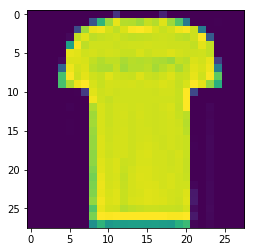

In [54]:
temp,e = mnist.train.next_batch(1)
print(temp.shape)
temp = temp.reshape(28,28)
plt.imshow(temp)

## Setup
Placeholders, hyper parameters, definitions

In [55]:
tf.reset_default_graph()
batchSize = 256

XIn = tf.placeholder(dtype= tf.float32, shape=[None, 28,28], name='X')
Y = tf.placeholder(dtype= tf.float32, shape=[None, 28,28], name='Y')
YFlat = tf.reshape(Y,shape=[-1,28*28])
keepProb = tf.placeholder(dtype=tf.float32, shape = (), name='keepProb')

decInChannels = 1
nLatent = 8

reshapedDim = [-1,7,7,decInChannels]
inputDecoder = 49*decInChannels//2

def leakyRelu (x, alpha = 0.3):
    return tf.maximum(x,tf.multiply(x,alpha))

## Encoder

In [56]:
def encoder(XIn, keepProb):
    activation = leakyRelu
    with tf.variable_scope("encoder", reuse= None):
        X = tf.reshape(XIn, shape=[-1,28,28,1])
        # First Con2D layer and dropout
        x = tf.layers.conv2d(X, filters = 64, kernel_size=4, strides = 2, padding= 'same', activation=activation)
        x = tf.nn.dropout(x, keepProb)
        # Second Con2D layer and dropout
        x = tf.layers.conv2d(x, filters = 64, kernel_size=4, strides = 2, padding= 'same', activation=activation)
        x = tf.nn.dropout(x, keepProb)
        # Third Con2D layer and dropout
        x = tf.layers.conv2d(x, filters = 64, kernel_size=4, strides = 1, padding= 'same', activation=activation)
        x = tf.nn.dropout(x, keepProb)
        # Flattening
        x = tf.contrib.layers.flatten(x)
        # Vector of means
        mn = tf.layers.dense(x,units= nLatent)
        # vector of standard deviation
        sd = 0.5* tf.layers.dense(x,units= nLatent)
        
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], nLatent]))
        
        z = mn+tf.multiply(epsilon, tf.exp(sd))
        
        return z,mn,sd

## Decoder

In [57]:
def decoder(sampledZ, keepProb):
    with tf.variable_scope('decoder', reuse=None):
        # Two fully connected layer
        x= tf.layers.dense(sampledZ, units= inputDecoder, activation = leakyRelu)
        x = tf.layers.dense(x, units= inputDecoder*2+1, activation = leakyRelu)
        x = tf.reshape(x, reshapedDim)
        
        # First Conv2D trnaspose layer + dropout
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides= 2, padding = 'same', activation = tf.nn.relu)
        x = tf.nn.dropout(x, keepProb)
        
        # Second Conv2D trnaspose layer + dropout
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides= 1, padding = 'same', activation = tf.nn.relu)
        x = tf.nn.dropout(x, keepProb)
        
        # Third Conv2D trnaspose layer + dropout
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides= 1, padding = 'same', activation = tf.nn.relu)
        x = tf.nn.dropout(x, keepProb)
        
        # Flatting the model
        x= tf.contrib.layers.flatten(x)
        # Fully connected
        x = tf.layers.dense(x, units = 28*28, activation = tf.nn.sigmoid)
        
        # Convert the shape into a cevtor of 28*28 
        img = tf.reshape(x, shape = [-1,28,28])
        return img

## Compile

In [58]:
%%time
sample, mn,sd = encoder(XIn, keepProb)
dec = decoder(sample,keepProb)

Wall time: 290 ms


In [59]:
%%time
unreshaped = tf.reshape(dec, [-1,28*28])
imgLoss = tf.reduce_sum(tf.squared_difference(unreshaped, YFlat),1)
latentLoss = -0.5*tf.reduce_sum(10.+2.0*sd - tf.square(mn) - tf.exp(2.0*sd),1)
loss= tf.reduce_mean (imgLoss + latentLoss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)

Wall time: 863 ms


In [60]:
%%time
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Wall time: 458 ms


# Train the model

In [83]:
%%time
batchSize = 64
for i in range(30000):
    batch = [np.reshape(b,[28,28]) for b in mnist.train.next_batch(batch_size=batchSize)[0]]
    sess.run(optimizer, feed_dict={XIn: batch, Y: batch, keepProb:0.8})
    
    if not i % 100:
        startTime = time.time()
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, imgLoss, latentLoss, mn, sd],
                                               feed_dict = {XIn: batch, Y: batch, keepProb: 1.0})
        #plt.imshow(np.reshape(batch[0],[28,28]),cmap = 'gray')
        #plt.show()
        #plt.imshow(d[0], cmap='gray')
        #plt.show()
        print(i, ls,np.mean(i_ls), np.mean(d_ls))

0 -10.4192 18.2341 -28.6533
100 -11.7948 16.022 -27.8167
200 -11.7396 16.8128 -28.5524
300 -11.6043 16.4853 -28.0895
400 -11.0933 17.3103 -28.4035
500 -11.7316 16.6959 -28.4275
600 -13.778 14.7788 -28.5567
700 -11.112 17.9414 -29.0534
800 -10.278 17.8208 -28.0988
900 -14.6243 13.8713 -28.4956
1000 -11.2498 17.1271 -28.3769
1100 -12.6462 15.663 -28.3092
1200 -13.8771 14.5699 -28.447
1300 -11.6157 16.2135 -27.8292
1400 -11.5729 16.8719 -28.4448
1500 -12.3459 15.9415 -28.2874
1600 -10.0638 18.2818 -28.3456
1700 -12.1354 15.929 -28.0644
1800 -12.3222 15.308 -27.6302
1900 -12.1343 16.2403 -28.3746
2000 -12.2565 16.4144 -28.6709
2100 -12.6406 15.9849 -28.6255
2200 -10.5826 17.6783 -28.2609
2300 -10.5194 18.014 -28.5334
2400 -13.674 14.6932 -28.3672
2500 -11.8752 16.1729 -28.0482
2600 -10.8262 17.1707 -27.997
2700 -13.0369 15.1305 -28.1675
2800 -12.1083 16.6557 -28.764
2900 -9.19898 19.1114 -28.3104
3000 -12.267 15.8511 -28.1181
3100 -13.7555 14.6439 -28.3994
3200 -13.6438 14.5054 -28.1492
33

26300 -11.5121 16.5723 -28.0844
26400 -12.5202 15.57 -28.0902
26500 -14.032 14.9096 -28.9415
26600 -12.6698 15.5377 -28.2075
26700 -14.8913 13.4071 -28.2984
26800 -11.5977 16.555 -28.1527
26900 -10.4151 17.7484 -28.1634
27000 -13.7538 14.535 -28.2888
27100 -13.6904 15.0129 -28.7033
27200 -14.1922 13.579 -27.7712
27300 -11.4735 16.678 -28.1514
27400 -12.1551 16.0399 -28.195
27500 -12.8046 15.034 -27.8386
27600 -12.2201 15.6067 -27.8268
27700 -12.6921 15.7037 -28.3958
27800 -12.8119 15.35 -28.1619
27900 -13.9245 13.7742 -27.6987
28000 -12.254 15.911 -28.165
28100 -14.0196 14.5287 -28.5483
28200 -11.6895 15.8324 -27.5219
28300 -14.1957 14.5665 -28.7622
28400 -13.1145 14.4198 -27.5343
28500 -13.6852 14.7511 -28.4363
28600 -11.0421 16.9055 -27.9476
28700 -13.3478 14.4871 -27.8349
28800 -14.8619 12.9171 -27.779
28900 -14.6162 13.5243 -28.1405
29000 -13.6831 14.6126 -28.2956
29100 -13.9566 14.137 -28.0935
29200 -15.1845 13.2488 -28.4333
29300 -13.8113 14.1953 -28.0066
29400 -13.7169 14.7596 -

## Sampling

In [87]:
%%time
sampleSize = 10
randoms = [np.random.normal(0,1,nLatent) for _ in range(sampleSize*sampleSize)]
imgs = sess.run(dec, feed_dict = {sample: randoms, keepProb: 1.0})
imgs = [np.reshape(imgs[i],[28,28]) for i in range(len(imgs))]

Wall time: 12 ms


## Visualization

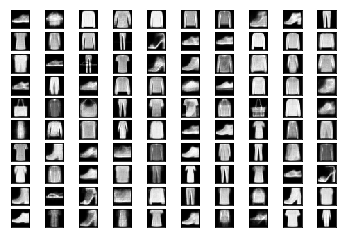

Wall time: 2.91 s


In [88]:
%%time

fig, axes = plt.subplots(sampleSize, sampleSize)
for i, ax in  enumerate (axes.ravel()):
    ax.matshow(imgs[i], cmap='gray')
    ax.set_xticks(())
    ax.set_yticks(())    
plt.show()

C:\Users\Ardavan\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Wall time: 2.41 s


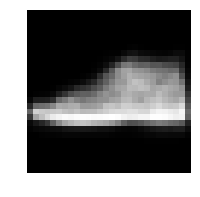

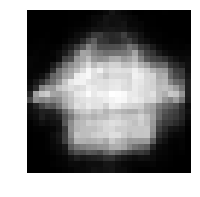

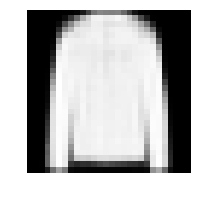

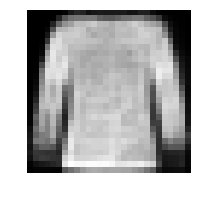

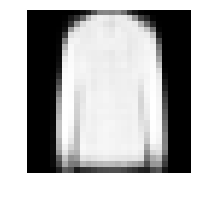

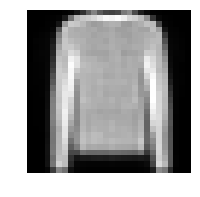

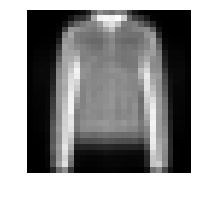

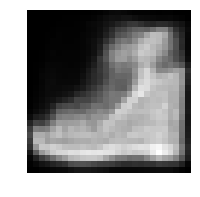

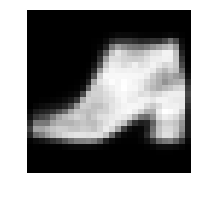

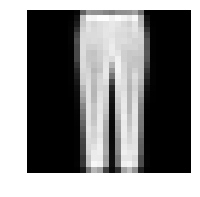

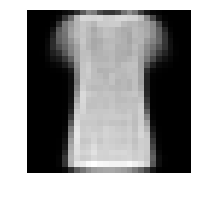

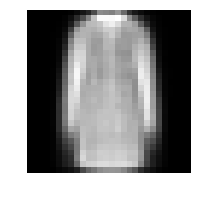

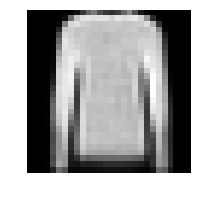

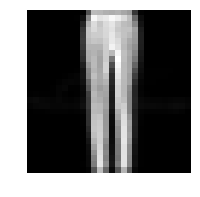

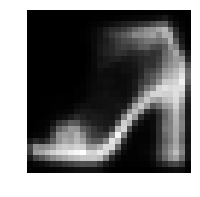

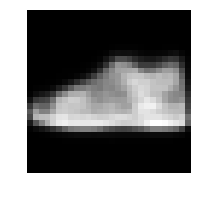

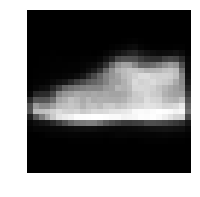

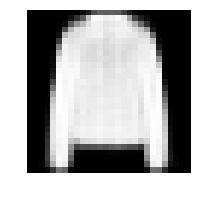

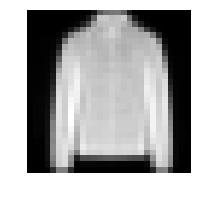

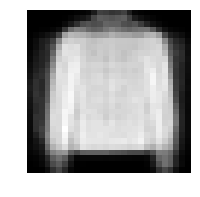

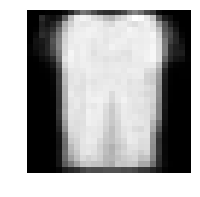

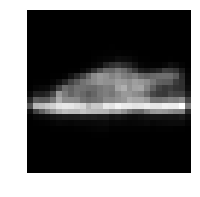

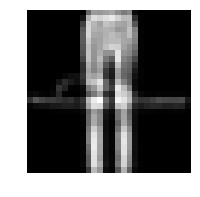

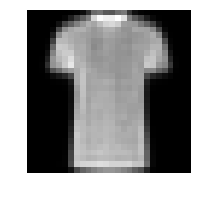

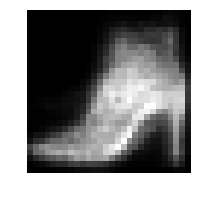

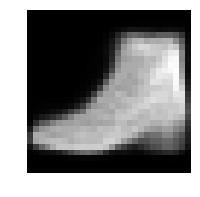

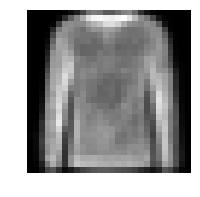

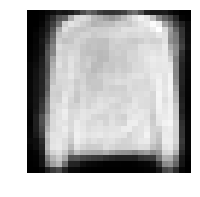

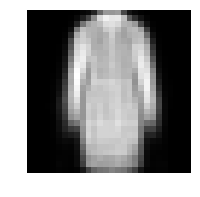

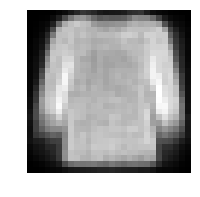

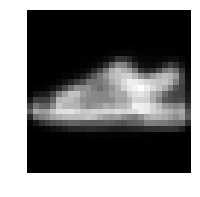

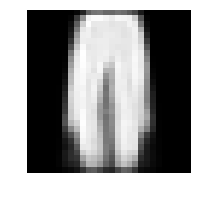

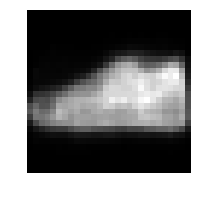

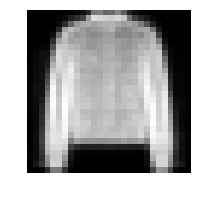

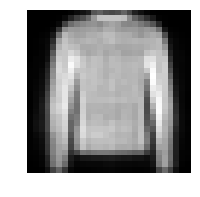

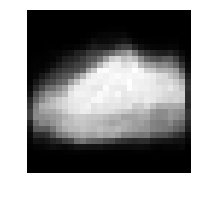

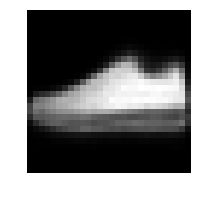

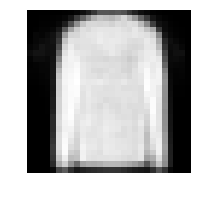

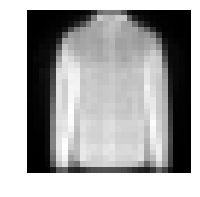

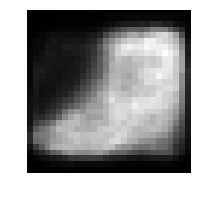

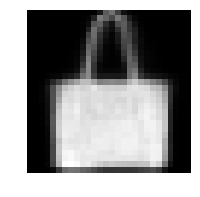

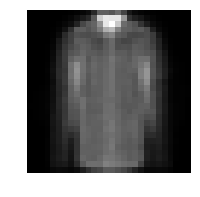

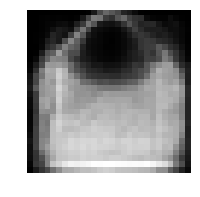

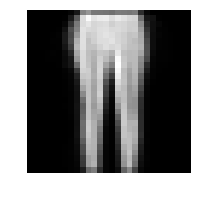

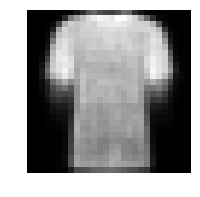

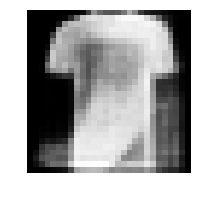

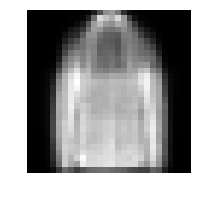

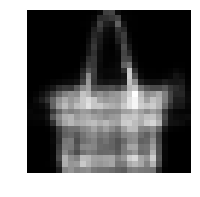

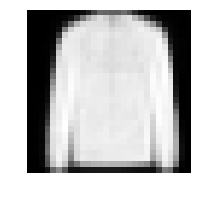

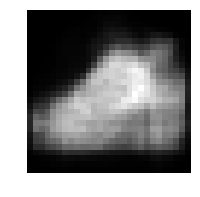

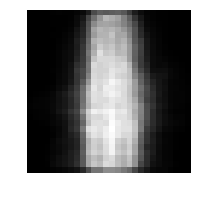

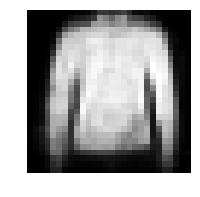

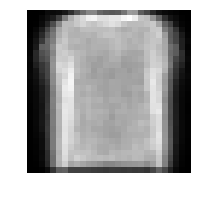

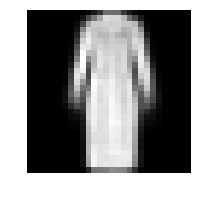

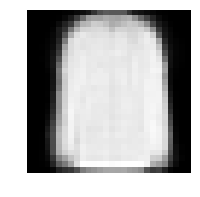

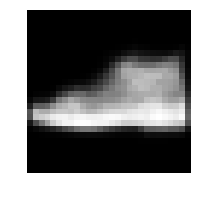

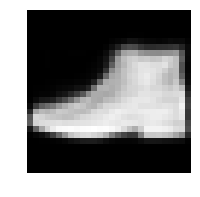

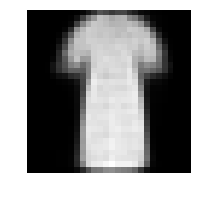

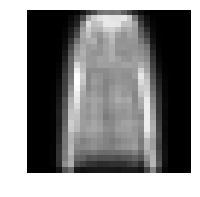

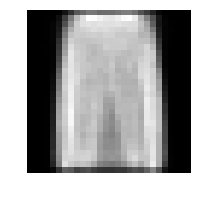

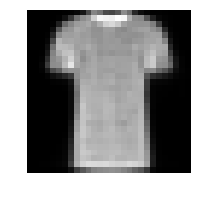

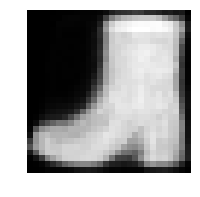

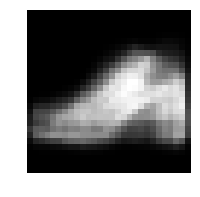

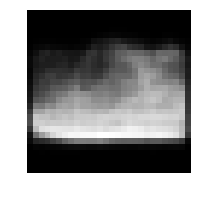

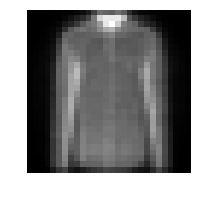

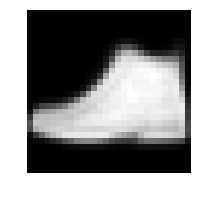

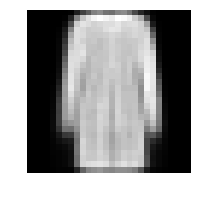

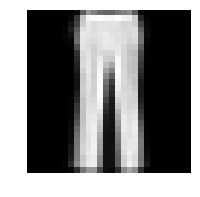

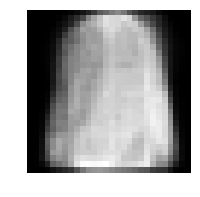

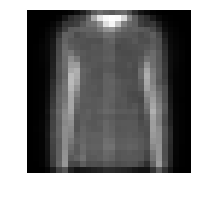

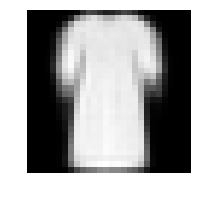

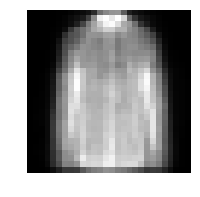

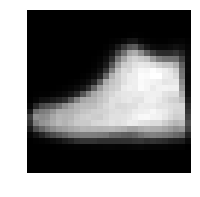

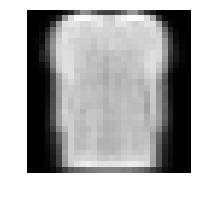

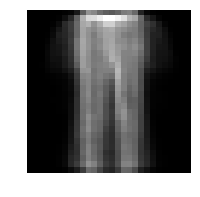

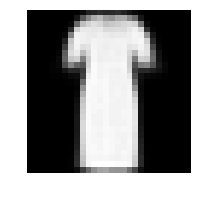

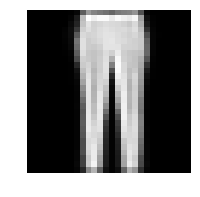

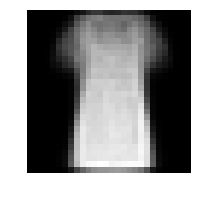

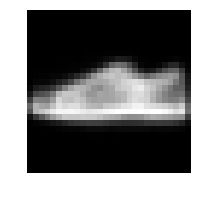

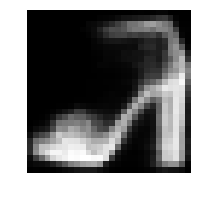

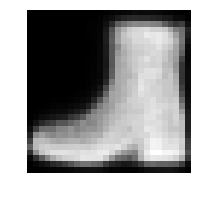

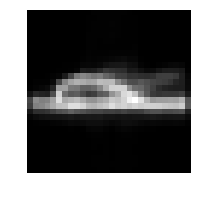

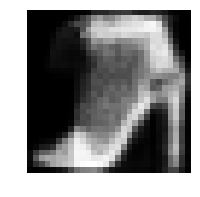

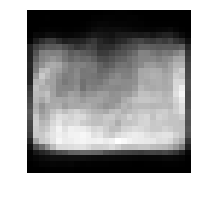

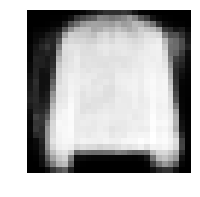

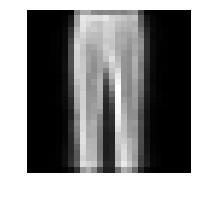

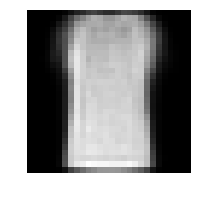

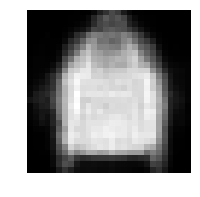

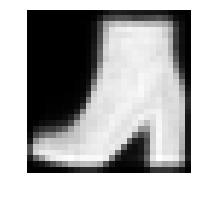

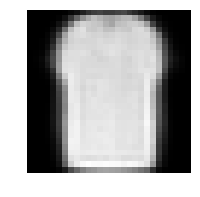

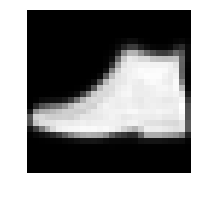

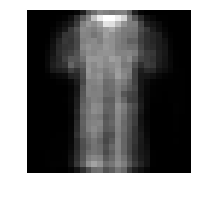

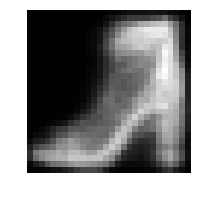

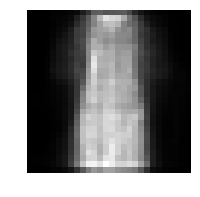

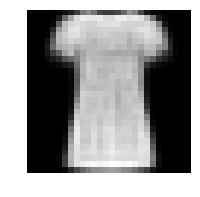

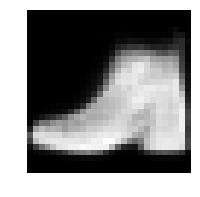

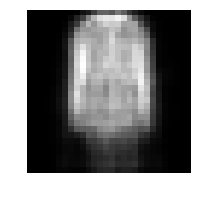

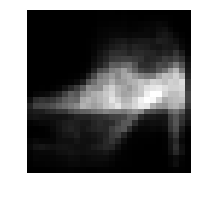

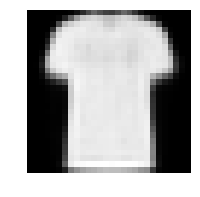

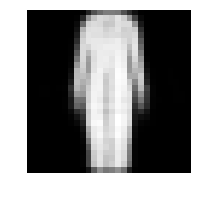

In [99]:
%%time
for i,img in enumerate (imgs):
    plt.figure(figsize=(3,3))
    plt.axis('off')
    name = "./generated/img{}.jpg".format(i)
    if i < 10:
        name = "./generated/img0{}.jpg".format(i)
    plt.imshow(img, cmap='gray')
    plt.imsave(name,img)
    